# Plot figure for validation

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

```
cd <my_path>/gud_groups
conda env create -f binder/environment.yml
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda activate gud_groups
jupyter notebook
```

Once the environment gud_groups is created, the Jupyter notebook can be launched simply with:

```
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda activate gud_groups
jupyter notebook
```

# First, load libraries

In [1]:
import datetime
import math
import matplotlib as mpl
import matplotlib.patches
import matplotlib.pyplot as plt
import netcdf_tools
import numpy as np
import pandas as pd
import pathlib
import os
import read_mitgcm
import scipy.interpolate
import statsmodels.nonparametric.smoothers_lowess
import tarfile
import vstats_pos

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
plt.close("all")

# Select year

In [4]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [5]:
gridfile='grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [6]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [7]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

# Observations

Create directory validation if it doesn't exit.

In [8]:
pathlib.Path("validation").mkdir(parents=True, exist_ok=True)

## Observations: sea ice concentration

The values of observed sea ice concentrations were boolean values of 0
and 1 because sea ice melted suddenly in only one day.
Here, these values were retrieved from the file of the forcing fields
of sea ice concentration.
We made sure these values corresponded to the expected values.

In [9]:
infile_sic=\
'../../gud_1d_35+16/input_noradtrans/input/siarea.qik.2016.365.32bits.bin'
array1d_iT_sic=np.fromfile(infile_sic,dtype='>f')

Sea ice break-up was on 18 July 2016, doy (0-based)=199.

In [10]:
obs_breakup=next(i for i,v in list(enumerate(array1d_iT_sic)) if v==0)

assert obs_breakup==199,\
'the day of year (0-based) of break-up from the file %s (obs_breakup=%r)'\
' is different from the day of year of break-up'\
' from Oziel et al., 2019 in Elem. Sci. Anth. (July 18=199).'\
% (infile_sic,obs_breakup)

## Observations: snow and ice thickness

The file Ice thickness from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ snow and ice thickness at the Green Edge sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'sample_thickness_cm_average' is the snow or ice thickness ($cm$).

### Observations: snow and ice thickness: load dataset

In [11]:
def load_thickness():
    fname='../../obs/66407.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_thickness_cm_average': np.float32,
                'sample_thickness_cm_sd': np.float32,
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    df['sample_thickness_m_average']=df['sample_thickness_cm_average'] \
    .apply(lambda x:x/100)
    return df

In [12]:
thickness_df=load_thickness()

### Observations: snow and ice thickness: select

We select the observations of snow thickness at the ice camp 2016.

In [13]:
snow_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                               & (thickness_df.sample_type=='snow')]
# snow_thickness_df[['date','sample_thickness_m_average']]

The start of the period without observed snow cover was defined as the
start of the melt pond period.
It was on 15 June 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [14]:
obs_nosnow=166 # 0-based

We select the observations of ice thickness at the ice camp 2016.

In [15]:
ice_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                              & (thickness_df.sample_type=='ice')]

## Observations: PAR

In $\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

Conversion factor from
$\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$
to
$\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

In [16]:
uEs2Ed=1E-6*86400

The file C-OPS from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ underwater PAR at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'averaged_par_d_fit_daily_ein_m_2_day_1' is the downwelling PAR (mol photons $\mathrm{ m^{-2} }$ $\mathrm{ d^{-1} }$).

Let $\mathrm{ I_i }$ the PAR just below sea ice.

PAR just below surface ($\mathrm{ 0^- }$) was observed only just
below sea ice ($\mathrm{ I_i }$).
PAR just below surface ($\mathrm{ 0^- }$) was not observed just
below open water ($\mathrm{ I_w }$).
Observed PAR ($\mathrm{ 0^- }$) was thus equivalent to 
observed PAR just below sea ice ($\mathrm{ I_i })$.

### Observations: PAR: load dataset

In [17]:
def load_par(fname):
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [18]:
infile_PAR_iceFile='../../obs/66399.csv'
par_df=load_par(infile_PAR_iceFile)

### Observations: PAR: select

In [19]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [20]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [21]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

### Observations: PAR: calculate

The first value of simulated PAR had a depth=0 m even when there was sea ice. The first value of observed PAR had a depth equals to the thickness of sea ice in the water. For example, if there was 1 m of sea ice in the water, the first value of observed PAR would be at depth=1 m. We changed that for a depth=0 m to be coherent with the simulated values. Indeed, we wanted to compare observed and simulated PAR at the same distance from the bottom of sea ice and not at the same distance from the water surface.

In [22]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=parwater_df.loc[(parwater_df.doy==doy),('depth')].min() # m
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']-ice_thickness

In [23]:
# mol photons m^-2 d^-1
array1d_iT_obsPAR0m=np.empty(365)
array1d_iT_obsPAR0m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    array1d_iT_obsPAR0m[doy-1]=\
    parwater_df.loc[(parwater_df.doy==doy) & (parwater_df.depth==0),
                    'par']

The first observation of PAR under sea ice was on 4 May,
doy (0-based)=124.

In [24]:
first_obs_PAR=np.where(~np.isnan(array1d_iT_obsPAR0m))[0][0]
first_obs_PAR
assert first_obs_PAR==124,\
'the day of year (0-based) of the first observation of PAR under sea ice'\
' from the file %s (first_obs_PAR=%r)'\
' is different from the expected value of 124 (May 4).'\
% (infile_PAR_iceFile,first_obs_PAR)

### Observations: PAR: 3 m

In [25]:
array1d_iT_obsPAR3m=np.empty(365)
array1d_iT_obsPAR3m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        parwater_df[parwater_df.doy==doy]['depth'],
        parwater_df[parwater_df.doy==doy]['par'])
    array1d_iT_obsPAR3m[doy-1]=y_interp(3)

### Observations: PAR: depth of the $\mathrm{ z_{0.415} }$ isolume

In [26]:
array1d_iT_obsisolume=np.empty(365)
array1d_iT_obsisolume[:]=np.NaN
c_isolume=0.415 # mol photons m^-2 d^-1
for doy in pd.unique(parwater_df['doy']):
    parwater_onedoy_df=parwater_df[parwater_df.doy==doy]
    if parwater_onedoy_df.iloc[0,:]['par'] > c_isolume:
        idx_isolume=vstats_pos.find_idx_nearest \
        (array=parwater_onedoy_df['par'],
         value=c_isolume)
        isolume=parwater_onedoy_df['depth'].iloc[idx_isolume]
        array1d_iT_obsisolume[doy-1]=isolume
# for i,v in enumerate(array1d_iT_obsisolume):
#     print(i,v)

In [27]:
array1d_iobs_doy\
=np.argwhere(np.logical_not(np.isnan(array1d_iT_obsisolume))).flatten()
array1d_iobs_obsisolume=array1d_iT_obsisolume[array1d_iobs_doy].flatten()
f=scipy.interpolate.interp1d(array1d_iobs_doy, array1d_iobs_obsisolume)
array1d_idomain_obsisolume_domain=np.arange(array1d_iobs_doy[0],
                                            array1d_iobs_doy[-1]+1)
array1d_idomain_obsisolume_interp=f(array1d_idomain_obsisolume_domain)
start=np.empty(array1d_iobs_doy[0])
start[:]=np.nan
end  =np.empty(365-1-array1d_iobs_doy[-1])
end  [:]=np.nan
array1d_iT_obsisolume_interp\
=np.concatenate((start,
                 array1d_idomain_obsisolume_interp,
                 end),
                axis=0)
# for i,v in enumerate(array1d_iT_obsisolume_interp):
#     print(i,v)

## Observations: nutrients

The file Nutrients from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ nutrients at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'no3_um_l', 'po4_um_l', and 'sioh4_um_l' are the nitrate, phosphate, and silicic acid concentrations, respectively ($\mathrm{ \mu }$M).

### Observations: nutrients: load dataset

In [28]:
def load_nutrients():
    fname='../../obs/66412.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'bottom_depth_m': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'filter_type': 'category',
                'quality_flag': 'category',
                'dilution_factor': np.float32,
                'no3_um_l': np.float32,
                'no2_um_l': np.float32,
                'no2_and_no3': np.float32,
                'po4_um_l': np.float32,
                'sioh4_um_l': np.float32,
                'n_ice_samples_ice_camp_2016': np.float32,
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                no3_um_l='no3',
                po4_um_l='po4',
                sioh4_um_l='sioh4'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [29]:
nutrients_df=load_nutrients()

### Observations: nutrients: select

We select the observations of nitrate at the ice camp 2016 in the water column made with a GFF filter.

In [30]:
nutrients_df=nutrients_df[(nutrients_df.mission=='ice_camp_2016') \
              & (nutrients_df.sample_type=='water') \
             & (nutrients_df.filter_type=='gff')]

Find duplicates.

In [31]:
g=nutrients_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

No duplicates.

### Observations: nutrients: 3 m

In [32]:
array1d_iT_obsnitrate3m=np.empty(365)
array1d_iT_obsnitrate3m[:]=np.NaN
array1d_iT_obssilica3m=np.empty(365)
array1d_iT_obssilica3m[:]=np.NaN
for doy in pd.unique(nutrients_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        nutrients_df[nutrients_df.doy==doy]['depth'],
        nutrients_df[nutrients_df.doy==doy]['no3'])
    array1d_iT_obsnitrate3m[doy-1]=y_interp(3)
for doy in pd.unique(nutrients_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        nutrients_df[nutrients_df.doy==doy]['depth'],
        nutrients_df[nutrients_df.doy==doy]['sioh4'])
    array1d_iT_obssilica3m[doy-1]=y_interp(3)

## Observations: $\mathrm{ \sum Chl\ } a$

$\mathrm{ \sum Chl\ } a$ is the vertically integrated Chl $a$ (0-100m)
in $\mathrm{ mg\ Chl\ m^{-2} }$.

The file Pigments, nutrients, Chlorophyll a and Phaeopigments (concentration) from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ chlorophyll *a* at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'conc_mg_m3' is the chlorophyll *a* concentration measured by HPLC (mg Chl $\mathrm{ m^{-3} }$).

### Observations: $\mathrm{ \sum Chl\ } a$: load dataset

In [33]:
def load_pigment():
    fname='../../obs/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                conc_ug_l='chlfluo',
                conc_mg_m3='chlHPLC'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [34]:
chlHPLC_df=load_pigment()

### Observations: $\mathrm{ \sum Chl\ } a$: select

We select the observations of chlorophyll a concentrations at the ice camp 2016 measured by HPLC.

In [35]:
chlHPLC_df=chlHPLC_df[(chlHPLC_df.mission=='ice_camp_2016') \
              & (chlHPLC_df.sample_type=='water') \
             & (chlHPLC_df.pigment=='Total Chlorophyll a') \
             & (chlHPLC_df.method=='HPLC')]

Make sure there is no negative Chl $a$.

In [36]:
chlHPLC_df['chlHPLC'][ chlHPLC_df['chlHPLC']<0 ]

Series([], Name: chlHPLC, dtype: float32)

Find duplicates.

In [37]:
g=chlHPLC_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

doy  depth
146  1.5      2.0
     10.0     2.0
Name: depth, dtype: float64

Inspect duplicates for doy=146.

In [38]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20357,0.5,0.1056,146
20358,1.5,0.0899,146
20359,5.0,0.0906,146
20360,10.0,0.0905,146
20361,20.0,0.1011,146
20362,40.0,0.0633,146
20363,0.5,0.0971,148
20364,1.5,0.1483,146
20365,5.0,0.1086,148
20366,10.0,0.0890,146


By human judgement, I replace the doy of rows 20364 and 20366 with 148.

In [39]:
chlHPLC_df.loc[[20364,20366],'doy']=148

In [40]:
# chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
# chlHPLC_oneday_df

Identify days of year for which the number of observations is less than or equal to 2. There are not measurements at enough depths to be able to calculate a meaningful vertical integration.

In [41]:
g=chlHPLC_df.groupby('doy')['doy'].value_counts()
g.where(g<=2).dropna()

doy  doy
120  120    2.0
Name: doy, dtype: float64

In [42]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==120)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20299,1.5,0.0355,120
20300,5.0,0.0253,120


By human judgement, I drop these observations.

In [43]:
chlHPLC_df=chlHPLC_df.drop(chlHPLC_df[(chlHPLC_df.doy==120)].index)

### Observations: $\mathrm{ \sum Chl\ } a$: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [44]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    70])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  70])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    70])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         75])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    70])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,20,    55])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,20,    22.5,32.5])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45,60])
weights_case8=np.array([     5.75,        9.25,10,12.5,15,47.5])

In [45]:
nT=365
array1d_iT_obsvintchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvintchlHPLC[iT]=obsvintchlHPLC

# Observations: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated carbon (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

The dataset is available from https://www.seanoe.org/data/00487/59892/ : Photosynthetic picoeukaryotes (abundance) & Phytoplankton measured by Imaging FlowCytobot. The principal investigators were Joannie Ferland, Pierre-Luc Grondin and Marcel Babin.

Reference:
Massicotte, P., Amiraux, R., Amyot, M.-P., Archambault, P., Ardyna, M., Arnaud, L., Artigue, L., Aubry, C., Ayotte, P., Bécu, G., Bélanger, S., Benner, R., Bittig, H. C., Bricaud, A., Brossier, É., Bruyant, F., Chauvaud, L., Christiansen-Stowe, D., Claustre, H., Cornet-Barthaux, V., Coupel, P., Cox, C., Delaforge, A., Dezutter, T., Dimier, C., Domine, F., Dufour, F., Dufresne, C., Dumont, D., Ehn, J., Else, B., Ferland, J., Forget, M.-H., Fortier, L., Galí, M., Galindo, V., Gallinari, M., Garcia, N., Gérikas Ribeiro, C., Gourdal, M., Gourvil, P., Goyens, C., Grondin, P.-L., Guillot, P., Guilmette, C., Houssais, M.-N., Joux, F., Lacour, L., Lacour, T., Lafond, A., Lagunas, J., Lalande, C., Laliberté, J., Lambert-Girard, S., Larivière, J., Lavaud, J., LeBaron, A., Leblanc, K., Le Gall, F., Legras, J., Lemire, M., Levasseur, M., Leymarie, E., Leynaert, A., Lopes dos Santos, A., Lourenço, A., Mah, D., Marec, C., Marie, D., Martin, N., Marty, C., Marty, S., Massé, G., Matsuoka, A., Matthes, L., Moriceau, B., Muller, P.-E., Mundy, C.-J., Neukermans, G., Oziel, L., Panagiotopoulos, C., Pangrazi, J.-J., Picard, G., Picheral, M., Pinczon du Sel, F., Pogorzelec, N., Probert, I., Quéguiner, B., Raimbault, P., Ras, J., Rehm, E., Reimer, E., Rontani, J.-F., Rysgaard, S., Saint-Béat, B., Sampei, M., Sansoulet, J., Schmechtig, C., Schmidt, S., Sempéré, R., Sévigny, C., Shen, Y., Tragin, M., Tremblay, J.-É., Vaulot, D., Verin, G., Vivier, F., Vladoiu, A., Whitehead, J., and Babin, M.: Green Edge ice camp campaigns: understanding the processes controlling the under-ice Arctic phytoplankton spring bloom, Earth Syst. Sci. Data, 12, 151–176, https://doi.org/10.5194/essd-12-151-2020, 2020.

## Observations: $\mathrm{ \sum C_{phyto} }$: load dataset

In [46]:
def load_groups():
    fname='../../obs/66408.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_name': 'string',
                'sample_type': 'category',
                'depth_m': np.float32,
                'sample_source': 'category',
                'snow_thickness': 'category',
                'ml_analyzed': np.float32,
                'dilution_factor': np.float32,
                'taxonomy': 'category',
                'carbon_estimate_mg_c_m3': np.float32,
                'nb_images_img_ml': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [47]:
groups_df=load_groups()

In [48]:
#doy: 120
depths_case1 =np.array([       1.5,  5])
weights_case1=np.array([       3.25, 96.75])
#doy: 123
depths_case2 =np.array([       1.5,  5,    10,    20,     40])
weights_case2=np.array([       3.25, 4.25,  7.5,  15,     70])
#doy: 125
depths_case3 =np.array([0,           5,    10,    20])
weights_case3=np.array([2.5,         5,     7.5,  85])
#doy: 127,130,134,141,144,153,155,158,160,162,165,167,169,172,174,176
depths_case4 =np.array([0,     1.5,  5,    10,    20,     40])
weights_case4=np.array([0.75,  2.5,  4.25,  7.5,  15,     70])
#doy: 132
depths_case5 =np.array([0,     1.5,  5,    10,            40])
weights_case5=np.array([0.75,  2.5,  4.25, 17.5,          75])
#doy: 137,139
depths_case6 =np.array([0,     1.5,  5,    10,    20])
weights_case6=np.array([0.75,  2.5,  4.25,  7.5,  85])
#doy: 179,181,183,186,188,190
depths_case7 =np.array([0,     1.5,        10,    20, 30,     60])
weights_case7=np.array([0.75,  5,           9.25, 10, 20,     55])
#doy: 193,195,200
depths_case8 =np.array([     1.5,         10,    20, 30,      60,   75])
weights_case8=np.array([     5.75,         9.25, 10, 20,      22.5, 32.5])
#doy: 197,182
depths_case9 =np.array([     1.5,        10,    20, 30,   45, 60])
weights_case9=np.array([     5.75,        9.25, 10, 12.5, 15, 47.5])

## Observations: $\mathrm{ \sum C_{phyto} }$: diatoms

We select the observations of diatoms at the Green Edge Sea Ice Camp in 2016.

In [49]:
diatomsnotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Attheya') \
    | (groups_df.taxonomy=='Centric diatoms') \
    | (groups_df.taxonomy=='Centric diatoms chains') \
    | (groups_df.taxonomy=='Chaetoceros') \
    | (groups_df.taxonomy=='Cylindrotheca closterium') \
    | (groups_df.taxonomy=='Entomoneis') \
    | (groups_df.taxonomy=='Eucampia') \
    | (groups_df.taxonomy=='Fragilariopsis') \
    | (groups_df.taxonomy=='Gyro_Pleurosigma') \
    | (groups_df.taxonomy=='Licmophora') \
    | (groups_df.taxonomy=='Melosira') \
    | (groups_df.taxonomy=='Navicula') \
    | (groups_df.taxonomy=='Navicula pelagica') \
    | (groups_df.taxonomy=='Navicula septentrionalis') \
    | (groups_df.taxonomy=='Nitzschia frigida') \
    | (groups_df.taxonomy=='Pennate diatoms') \
    | (groups_df.taxonomy=='Pennate diatoms chains') \
    | (groups_df.taxonomy=='Porosira') \
    | (groups_df.taxonomy=='Pseudo-nitzschia') \
    | (groups_df.taxonomy=='Rhizosolenia') \
    | (groups_df.taxonomy=='Thalassiosira') \
    | (groups_df.taxonomy=='Thalassiosira nordenskioeldii') \
) \
                              ]

In [50]:
diatoms_df=diatomsnotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()

In [51]:
nT=365
array1d_iT_obsdiatomvint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdiatomvint=np.NaN
    obsdiatom=[]
    doy=iT+1
    obsdiatom_oneday_df=diatoms_df[['depth','carbon_estimate_mg_c_m3']][(diatoms_df.doy==doy)]
    depths=obsdiatom_oneday_df['depth']
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(),
#                       depths_case1):
#         for depth in depths:
#             obsdiatomtempo \
#             =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
#             assert obsdiatomtempo.size==1
#             obsdiatomtempo=obsdiatomtempo.iat[0]
#             obsdiatom.append(obsdiatomtempo)
#         obsdiatomvint=np.dot(obsdiatom,weights_case1)
    if np.array_equal(depths.sort_values(),
                      depths_case2):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case2)
    if np.array_equal(depths.sort_values(),
                      depths_case3):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case3)
    if np.array_equal(depths.sort_values(),
                      depths_case4):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case4)
    if np.array_equal(depths.sort_values(),
                      depths_case5):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case5)
    if np.array_equal(depths.sort_values(),
                      depths_case6):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case6)
    if np.array_equal(depths.sort_values(),
                      depths_case7):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case7)
    if np.array_equal(depths.sort_values(),
                      depths_case8):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case8)
    if np.array_equal(depths.sort_values(),
                      depths_case9):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case9)
    array1d_iT_obsdiatomvint[iT]=obsdiatomvint

## Observations: $\mathrm{ \sum C_{phyto} }$: dinoflagellates

We select the observations of dinoflagellates at the Green Edge Sea
Ice Camp in 2016.

In [52]:
dinonotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Cryptophytes') \
    | (groups_df.taxonomy=='Dinoflagellates') \
    | (groups_df.taxonomy=='Euglenozoa') \
    | (groups_df.taxonomy=='Neoceratium') \
    | (groups_df.taxonomy=='Peridiniella catenata') \
    | (groups_df.taxonomy=='Polarella glacialis')
) \
                              ]

In [53]:
dino_df=dinonotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()

In [54]:
nT=365
array1d_iT_obsdinovint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdinovint=np.NaN
    obsdino=[]
    doy=iT+1
    obsdino_oneday_df=dino_df[['depth','carbon_estimate_mg_c_m3']][(dino_df.doy==doy)]
    depths=obsdino_oneday_df['depth']
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths:
#             obsdinotempo \
#             =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
#             assert obsdinotempo.size==1
#             obsdinotempo=obsdinotempo.iat[0]
#             obsdino.append(obsdinotempo)
#         obsdinovint=np.dot(obsdino,weights_case1)
    if np.array_equal(depths.sort_values(),
                      depths_case2):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case2)
    if np.array_equal(depths.sort_values(),
                      depths_case3):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case3)
    if np.array_equal(depths.sort_values(),
                      depths_case4):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case4)
    if np.array_equal(depths.sort_values(),
                      depths_case5):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case5)
    if np.array_equal(depths.sort_values(),
                      depths_case6):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case6)
    if np.array_equal(depths.sort_values(),
                      depths_case7):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case7)
    if np.array_equal(depths.sort_values(),
                      depths_case8):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case8)
    if np.array_equal(depths.sort_values(),
                      depths_case9):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case9)
    array1d_iT_obsdinovint[iT]=obsdinovint

## Observations: $\mathrm{ \sum C_{phyto} }$: other nanphytoplankton

We select the observations of dinoflagellates at the Green Edge Sea
Ice Camp in 2016.

In [55]:
othernotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy==  'Anabaena') \
    | (groups_df.taxonomy=='Ciliates') \
    | (groups_df.taxonomy=='Dictyocha') \
    | (groups_df.taxonomy=='Flagellates') \
    | (groups_df.taxonomy=='Other phytoplankton') \
    | (groups_df.taxonomy=='Phaeocystis')
) \
                              ]

In [56]:
other_df=othernotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()

In [57]:
nT=365
array1d_iT_obsothervint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsothervint=np.NaN
    obsother=[]
    doy=iT+1
    obsother_oneday_df=other_df[['depth','carbon_estimate_mg_c_m3']][(other_df.doy==doy)]
    depths=obsother_oneday_df['depth']
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths:
#             obsothertempo \
#             =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
#             assert obsothertempo.size==1
#             obsothertempo=obsothertempo.iat[0]
#             obsother.append(obsothertempo)
#         obsothervint=np.dot(obsother,weights_case1)
    if np.array_equal(depths.sort_values(),
                      depths_case2):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case2)
    if np.array_equal(depths.sort_values(),
                      depths_case3):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case3)
    if np.array_equal(depths.sort_values(),
                      depths_case4):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case4)
    if np.array_equal(depths.sort_values(),
                      depths_case5):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case5)
    if np.array_equal(depths.sort_values(),
                      depths_case6):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case6)
    if np.array_equal(depths.sort_values(),
                      depths_case7):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case7)
    if np.array_equal(depths.sort_values(),
                      depths_case8):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case8)
    if np.array_equal(depths.sort_values(),
                      depths_case9):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case9)
    array1d_iT_obsothervint[iT]=obsothervint

## Observations: $\mathrm{ \sum C_{phyto} }$: all

In [58]:
array1d_iT_obsvintcphyto=\
array1d_iT_obsdiatomvint+array1d_iT_obsdinovint+array1d_iT_obsothervint

## Observations: mixing layer

The depth of the mixing layer was 25 m on June 23, 2016
(Oziel et al., 2019, in $Elem\ Sci\ Anth$).

In [59]:
obsKz=25
obsKz_date=174

## Observations: equivalent mixed layer depth

In m.

The equivalent mixed layer depth was calculated with the method of
Randelhoff et al. (2017) in $J\ Phys\ Ocean$.
doi:10.1175/JPO-D-16-0200.1.

The observations are plotted in the Figure 10 of 
Oziel et al., 2019, in $Elem\ Sci\ Anth$.
The values are from the file PARAMETERS_ZEU_HBD_TCHLA_FOR_LEO_2016.mat that Leo Lacour sent me on August 19, 2020.
The variable HBD was processed with my private project
https://github.com/maximebenoitgagne/hBD to smooth the values with the
parameter med=7.

In [60]:
def load_hBD(fname):
    df1 = (
        pd.read_csv(
            fname,
            dtype={
                'doy_1based': np.int32,
                'hBD_m': np.float32
            },
        )
        .rename(
            columns=dict(
                hBD_m='hBD'
            )
        )
    )
    df1['doy']=df1['doy_1based'].apply(lambda x:x-1) # 0-based
    df2=pd.DataFrame(df1[['doy','hBD']])
    return df2

In [61]:
infile_hBD='../../obs/hBD.csv'
hBD_df=load_hBD(infile_hBD)

# NEMO-LIM3

## NEMO-LIM3: simulated sea ice freeze-up

In [62]:
infile_sicFile='../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin'
array1d_iT_forsic=np.fromfile(infile_sicFile,dtype='>f4')

The simulated sea ice freeze-up was on 24 November, doy (0-based)=328.

In [63]:
sim_freezeup\
=next(i for i,v in reversed(list(enumerate(array1d_iT_forsic))) if v < 0.50)

In [64]:
sim_freezeup

328

# Model NEMO-LIM3: vertical turbulent diffusivity ($\mathrm{K_z}$)

In $\mathrm{ m^2\ s^{-1} }$.

In [65]:
indir='../../gud_1d_35+16/input_noradtrans/input/NEMO_GE_2016'
if not os.path.isdir(indir):
    tar=tarfile.open(indir+'.tar')
    tar.extractall(path=os.path.dirname(indir))
    tar.close()
YYYY=2016
ndays=first_year.size
ndepths=RC.size
array2d_idepth_iT_Kz=np.empty((ndepths,ndays))
array2d_idepth_iT_Kz[:,:]=np.NaN
for iT in first_year:
    timestamp=(YYYY-1979)*ndays*36+(iT+1)*36
    Kzfile=os.path.join(indir,
                       'KPPdiffS.'+str(timestamp).zfill(10)+'.data')
    array1d_iT_Kz=np.fromfile(Kzfile,dtype='>f')
    array2d_idepth_iT_Kz[:,iT]=array1d_iT_Kz

In [66]:
depth_Kzmin=2
depth_Kzmax=350

### Model NEMO-LIM3: vertical turbulent diffusivity ($\mathrm{K_z}$): $\mathrm{ K_z=10^{-4}\ m^2\ s^{-1} }$

Depth with a $\mathrm{ K_z =10^{-4} }$.
In m.
This depth is relevant for the period of complete or partial sea ice
cover.

In [67]:
c_isoKz1=1E-4 # m^2 s^-1
array1d_iT_modisoKz1=np.empty(365)
array1d_iT_modisoKz1[:]=np.NaN
for iT in first_year:
    array1d_idepth_Kz=array2d_idepth_iT_Kz[:,iT]
    idx_isoKz1\
    =vstats_pos.find_idx_nearest(array=array1d_idepth_Kz,
                                 value=c_isoKz1)
    isoKz1=RC[idx_isoKz1]
    array1d_iT_modisoKz1[iT]=isoKz1
mask=(array1d_iT_modisoKz1<depth_Kzmin) \
| (array1d_iT_modisoKz1>depth_Kzmax)
array1d_iT_modisoKz1[mask]=np.NaN
# for i,v in enumerate(array1d_iT_modisoKz1):
#     print(i,v)

LOWESS.

In [68]:
x=first_year
y=array1d_iT_modisoKz1
# frac=2/3 is the default
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/15)
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points
# and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False)
# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
# Find y values based on the interpolation method
array1d_iT_modisoKz1lowess=f_linear(xnew)
# Construct the array of length 365
start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_modisoKz1lowess=np.concatenate((start_edge,
                                           array1d_iT_modisoKz1lowess,
                                           end_edge))

# Model MITgcm

In [69]:
carfile='car.0000000000.t001.nc'

## Model MITgcm: PAR

In [70]:
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PARfullumolEonm2s\
=netcdf_tools.read_netcdf(carfile,'PAR').squeeze().transpose()
if np.all(array2d_idepth_iT_PARfullumolEonm2s==0):
    #define GUD_PARUICE
    array2d_idepth_iT_PAR_icefullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ice').squeeze().transpose()
    array2d_idepth_iT_PAR_icefull\
    =array2d_idepth_iT_PAR_icefullumolEonm2s*1e-6*stod
    array2d_idepth_iT_PAR_owfullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ow').squeeze().transpose()
    array2d_idepth_iT_PAR_owfull\
    =array2d_idepth_iT_PAR_owfullumolEonm2s*1e-6*stod
    (ndepths,ndays)=array2d_idepth_iT_PAR_icefull.shape
    array2d_idepth_iT_icefull\
    =np.tile(array1d_iT_sic,(ndepths,ndays//365))
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PAR_owfull*(1-array2d_idepth_iT_icefull)\
    +array2d_idepth_iT_PAR_icefull*array2d_idepth_iT_icefull
else:
    #undef GUD_PARUICE
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PARfullumolEonm2s*1e-6*stod
array2d_idepth_iT_meanPAR=array2d_idepth_iT_meanPARfull[:,array1d_iT1y_iT]

### Model MITgcm: PAR: 3 m

In [71]:
(ndepths,ndays)=array2d_idepth_iT_meanPAR.shape
array1d_iT_modPAR3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_meanPAR[3,iT],array2d_idepth_iT_meanPAR[2,iT]]
    PAR3m=np.interp(x,xp,fp)
    array1d_iT_modPAR3m[iT]=PAR3m

($\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [72]:
array2d_idepth_iT_meanPARumolEonm2s=array2d_idepth_iT_meanPAR/1e-6/stod

### Model MITgcm: PAR: depth of the $\mathrm{ z_{0.415} }$ isolume

In m.

In [73]:
c_isolume=0.415 # mol photons m^-2 d^-1
(ndepths,ndays)=array2d_idepth_iT_meanPAR.shape
array1d_iT_modisolume=np.empty(ndays)
array1d_iT_modisolume[:]=np.NaN
for iT in first_year:
    array1d_idepth_meanPAR=array2d_idepth_iT_meanPAR[:,iT]
    if array1d_idepth_meanPAR[0]>c_isolume:
        idx_isolume=vstats_pos.find_idx_nearest(array=array1d_idepth_meanPAR,
                                                value=c_isolume)
        isolume=RC[idx_isolume]
        array1d_iT_modisolume[iT]=isolume

## Model MITgcm: nutrients

In [74]:
array2d_idepth_iT_modno3full=netcdf_tools.read_netcdf(carfile, 'TRAC04').squeeze().transpose()
array2d_idepth_iT_modno3=array2d_idepth_iT_modno3full[:,array1d_iT1y_iT]
array2d_idepth_iT_modsioh4full=netcdf_tools.read_netcdf(carfile, 'TRAC06').squeeze().transpose()
array2d_idepth_iT_modsioh4=array2d_idepth_iT_modsioh4full[:,array1d_iT1y_iT]
array2d_idepth_iT_modpo4full=netcdf_tools.read_netcdf(carfile, 'TRAC05').squeeze().transpose()
array2d_idepth_iT_modpo4=array2d_idepth_iT_modpo4full[:,array1d_iT1y_iT]

### Model MITgcm: nutrients: 3 m

in $\mathrm{ \mu M }$

In [75]:
(ndepths,ndays)=array2d_idepth_iT_modno3.shape
array1d_iT_modnitrate3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_modno3[3,iT],array2d_idepth_iT_modno3[2,iT]]
    nitrate3m=np.interp(x,xp,fp)
    array1d_iT_modnitrate3m[iT]=nitrate3m
(ndepths,ndays)=array2d_idepth_iT_modsioh4.shape
array1d_iT_silicicacid3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_modsioh4[3,iT],array2d_idepth_iT_modsioh4[2,iT]]
    silica3m=np.interp(x,xp,fp)
    array1d_iT_silicicacid3m[iT]=silica3m

# Model MITgcm: $\mathrm{ \sum Chl\ } a$

$\mathrm{ \sum Chl\ } a$ is the vertically integrated Chl $a$ (0-100m)
in $\mathrm{ mg\ Chl\ m^{-2} }$.

In [76]:
indir_exp0='.'

In [77]:
chlfile=os.path.join(indir_exp0,'chl.0000000000.t001.nc')
array2d_idepth_iT_modchlfull=\
read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
array2d_idepth_iT_modchl=array2d_idepth_iT_modchlfull[:,array1d_iT1y_iT]

In [78]:
# get vertically integrated Chl a for one year}
def get_array1d_iT_vintchl(indir,array1d_iT1y_iT,depth_end):
    chlfile=os.path.join(indir,'chl.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_chlfull=\
    read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
    # mg Chl-a m^-2
    array1d_iT_vintchlfull\
    =vstats_pos.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_chlfull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintchl=array1d_iT_vintchlfull[array1d_iT1y_iT]
    return array1d_iT_vintchl

### Model: $\mathrm{ \sum Chl\ } a$: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [79]:
depth_end=100
array1d_iT_modvintchl\
=get_array1d_iT_vintchl(indir_exp0,array1d_iT1y_iT,depth_end)

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

In [80]:
array1d_iT_acc=np.empty(365)
array1d_iT_acc[:]=np.NaN
for iT in np.arange(1,365):
    chl_iT=array1d_iT_modvintchl[iT]
    chl_iTm1=array1d_iT_modvintchl[iT-1]
    acc=(chl_iT-chl_iTm1)/chl_iTm1
    array1d_iT_acc[iT]=acc

In [81]:
found=False
iT=6
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_acc[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
date_initiation=iT
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_initiations=\
datetime.datetime(year,1,1) + datetime.timedelta(date_initiation)

Day of year

In [82]:
date_initiation+1

144

In [83]:
date_initiations.strftime("%B %d")

'May 23'

In [84]:
c_I=array1d_iT_modvintchl[date_initiation]

(in $mg\ Chl\ m^{-2}$)

In [85]:
c_I

2.0554721735792483

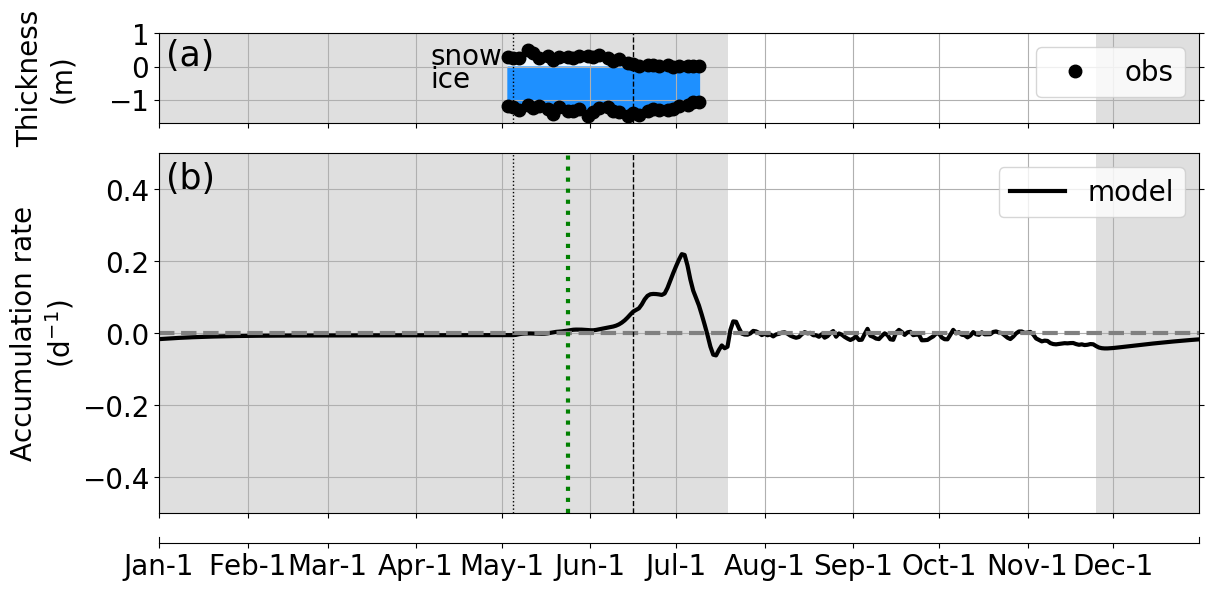

In [86]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.3,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.40,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.75,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')

    # --- ACCUMULATION RATE
    ax=axs[1]
    ymin=-0.5
    ymax= 0.5
    h1=ax.plot(first_year,array1d_iT_acc,
               '-',color='black',lw=3,label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Accumulation rate\n($\mathrm{ d^{-1} }$)')
    ax.grid()
    ax.legend(loc='upper right')
    ax.plot(xlims,[0,0],'k--',color='gray')
    plt.text(0.03,0.93,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,0.15])
    axs[1].set_position( [0.12,0.15  ,0.65,0.60])
    axs[2].set_position( [0.12,0.10  ,0.65,0.01])

with plt.style.context('thickness_PAR_nutrients_C_Chla_Kz_hBD_isolume.mplstyle'):
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(16,6))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='chl.0000000000.t001.r.png'
    plt.savefig(outfile)

Figure <exp0_r>.
Model accumulation rates.
(a) Observed snow and ice thickness.
(b) Model accumulation rates for the reference simulation (EXP-0).

The vertical black dotted line is the date of the first PAR observations.
The vertical black dashed line is the date of the snow melt completion.
The green dotted line is the date of the simulated bloom initiation. 
The grey rectangles represent the time of year before the observed sea ice break-up and after the simulated sea ice freeze-up.

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated, 0-100m) chlorophyll $a$.

In [87]:
date_peak=np.nanargmax(array1d_iT_modvintchl)
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_peaks=\
datetime.datetime(year,1,1) + datetime.timedelta(date_peak.item())

Day of year

In [88]:
date_peak+1

192

In [89]:
date_peaks.strftime("%B %d")

'July 10'

In [90]:
c_P=array1d_iT_modvintchl[date_peak]

(in $mg\ Chl\ m^{-2}$)

In [91]:
c_P

54.96791553265067

## Model MITgcm: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

In [92]:
# get vertically integrated carbon biomass for 
# diatoms+dinoflagellates+other nanophytoplankton for one year
# in mg C m^-2
def get_array1d_iT_vintbiodiatomdinoother(indir,
                                          array1d_iT1y_iT,depth_end):
    cphytofile=os.path.join(indir,'car.0000000000.t001.nc')
    # mg Chl a m^-3
    array2d_idepth_iT_diatombiofull=\
    read_mitgcm.get_array2d_idepth_iT_diatombiofull(cphytofile)
    array2d_idepth_iT_dinobiofull=\
    read_mitgcm.get_array2d_idepth_iT_dinobiofull(cphytofile)
    array2d_idepth_iT_otherbiofull=\
    read_mitgcm.get_array2d_idepth_iT_otherbiofull(cphytofile)
    array2d_idepth_iT_biodiatomdinootherfull=\
    array2d_idepth_iT_diatombiofull+array2d_idepth_iT_dinobiofull\
    +array2d_idepth_iT_otherbiofull
    # mg Chl a m^-2
    array1d_iT_vintbiodiatomdinootherfull\
    =vstats_pos.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_biodiatomdinootherfull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintbiodiatomdinoother\
    =array1d_iT_vintbiodiatomdinootherfull[array1d_iT1y_iT]
    return array1d_iT_vintbiodiatomdinoother

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: vertically integrated biomass (0-100m)

In $\mathrm{ mg\ C\ m^{-2} }$.

In [93]:
indir_exp0='.'
depth_end=100
array1d_iT_modvintcphytodiatomdinoother\
=get_array1d_iT_vintbiodiatomdinoother(indir_exp0,array1d_iT1y_iT,depth_end)

# Plot

## Plot: thickness, PAR, nutrients, $\mathrm{ \sum C_{phyto} }$, $\mathrm{ \sum Chl\ } a$, $\mathrm{ K_z}$, $\mathrm{ h_{BD} }$ and isolume

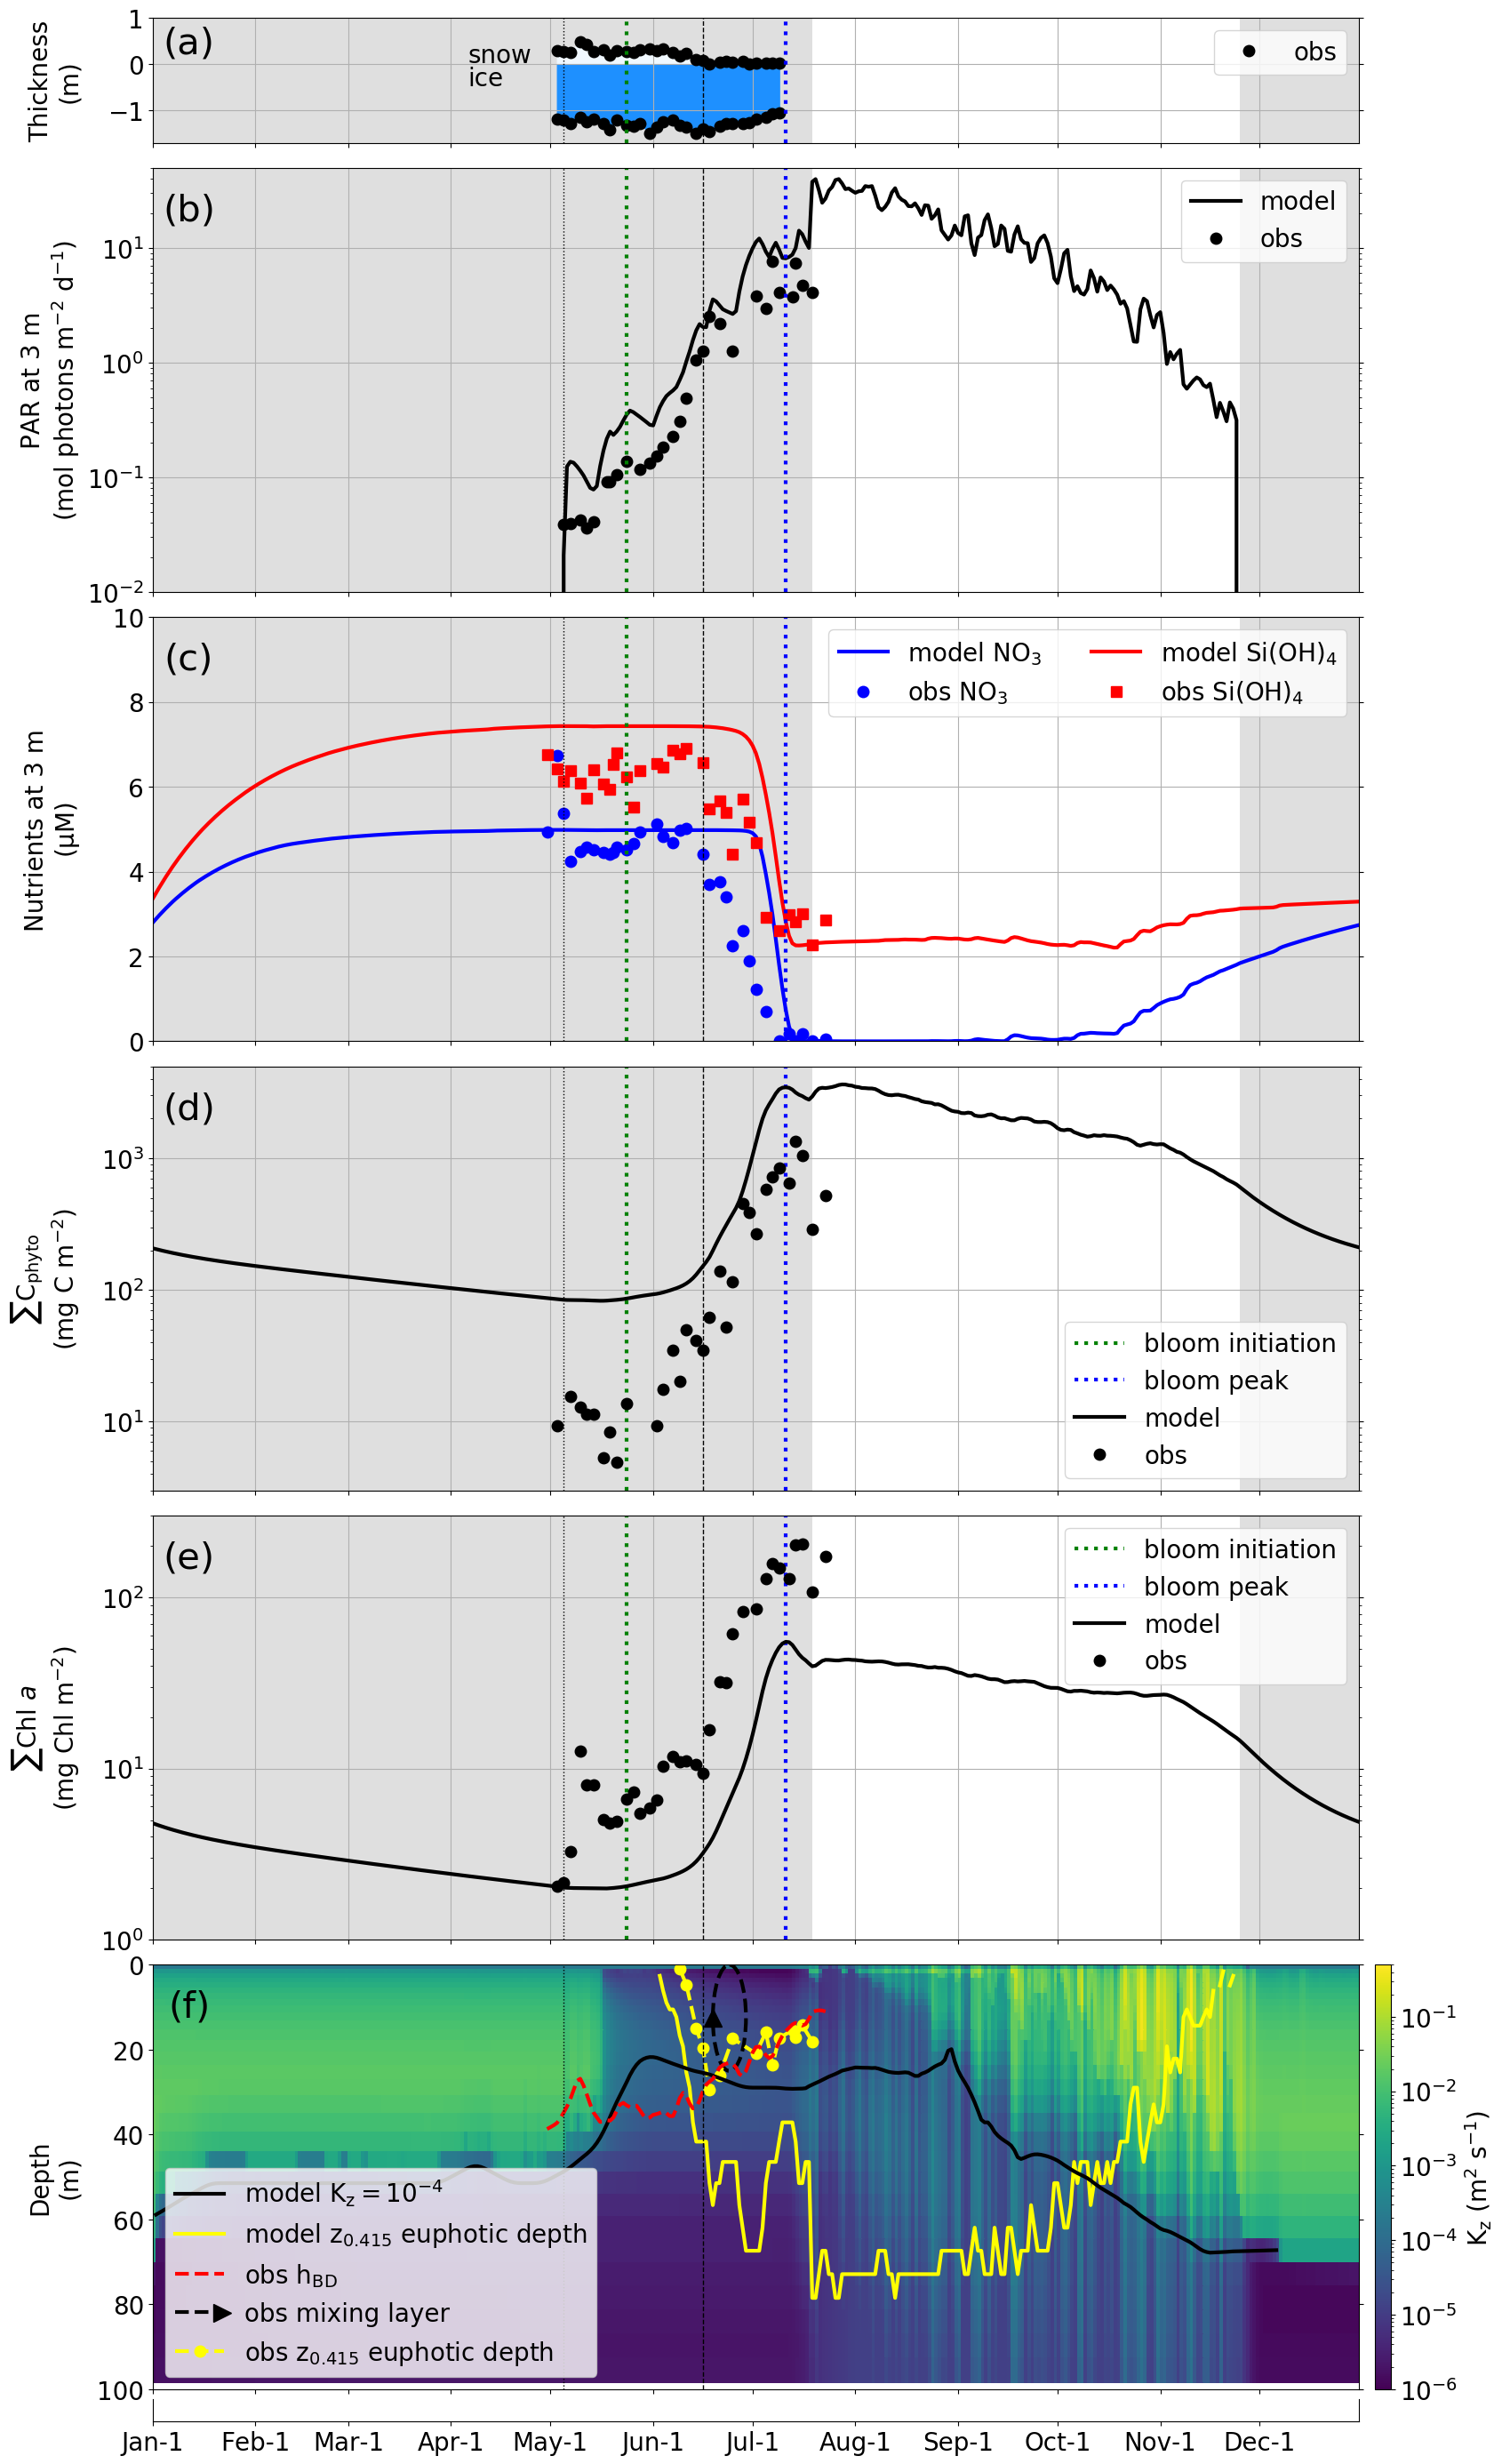

In [94]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.80,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')

    # --- PAR AT 3 m
    ax=axs[1]
    ymin=1E-2
    ymax=5E1
    h1=ax.plot(first_year,array1d_iT_modPAR3m,
               '-',color='black',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('PAR at 3 m\n(mol photons m$^{-2}$ d$^{-1})$',bbox=box)
    ax.grid()
    h2=ax.plot(first_year,array1d_iT_obsPAR3m,
               'o',color='black',label='obs')
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')

    # --- NUTRIENTS
    ax=axs[2]
    ymin=0
    ymax=10
    h1=ax.plot(first_year,array1d_iT_modnitrate3m,'-',color='blue')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Nutrients at 3 m\n($\mathrm{ \mu M }$)',bbox=box)
    ax.grid()
    h2=ax.plot(first_year,array1d_iT_silicicacid3m ,'-',color='red')
    h3=ax.plot(first_year,array1d_iT_obsnitrate3m,
               'o',color='blue')
    h4=ax.plot(first_year,array1d_iT_obssilica3m ,
               's',color='red')
    ax.legend([h1[0],h3[0],
               h2[0],h4[0]],
              ['model $\mathrm{ NO_3 }$','obs $\mathrm{ NO_3 }$',
               'model $\mathrm{ Si{(OH)}_4 }$','obs $\mathrm{ Si{(OH)}_4 }$'],
              loc='upper right', ncol=2)
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    # -- SUM C_PHYTO
    ax=axs[3]
    # I considered doy=124 with an observed Sum C_phyto=0.3 as an outlier
    ymin=3
    ymax=5000
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    h1=ax.plot(first_year,array1d_iT_modvintcphytodiatomdinoother,
               '-',color='black',lw=3,label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphyto,
               'o',color='black',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='lower right')
    
    # --- SUM CHL A
    ax=axs[4]
    ymin=1
    ymax=300
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    h2=ax.plot(first_year,array1d_iT_modvintchl,
               '-',color='black',lw=3,label='model')
    h4=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',color='black',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} Chl\ }a$\n'
                  '($\mathrm{ mg\ Chl\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='upper right')
    
    # --- PHYSICAL VARIABLES
    ax=axs[5]
    ymin=0
    ymax=100
    RF_above100=RF[RF<100]
    
    # model Kz
    h=ax.pcolormesh(first_year366,
                    RF_above100,
                    array2d_idepth_iT_Kz[0:(RF_above100.size)-1,:],
                    cmap='viridis',
                    norm=mpl.colors.LogNorm(vmin=1E-6, vmax=0.5))
    
    # observed z_0415 euphotic depth
    h5=ax.plot(first_year,array1d_iT_obsisolume,
           'o',linewidth=3,color='yellow',linestyle='--',
           label='obs $\mathrm{ z_{0.415} }$ euphotic depth')
    ax.plot(first_year,array1d_iT_obsisolume_interp,
           linewidth=3,color='yellow',linestyle='--')
    
    # simulated z_0415 euphotic depth
    h2=ax.plot(first_year,array1d_iT_modisolume,
           linewidth=3,color='yellow',linestyle='-',
           label='model $\mathrm{ z_{0.415} }$ euphotic depth')
    
    # model Kz=10^-4
#     h1=ax.plot(first_year,array1d_iT_modisoKz1,
#             color='black',
#             label='model $\mathrm{ K_z=10^{-4} } $')
    h1=ax.plot(first_year,array1d_iT_modisoKz1lowess,
            color='black',
            label='model $\mathrm{ K_z=10^{-4} } $')
    cbaxes = fig.add_axes([0.88, 0.03, 0.01, 0.17])
    cbar=plt.colorbar(h,cax = cbaxes)
    cbar.set_label('$\mathrm{ K_z }$ ($\mathrm{ m^2\ s^{-1} }$)')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.invert_yaxis()
    ax.set_ylabel('Depth\n(m)')
    
    # observed mixing layer
    xy=obsKz_date,obsKz/2
    width,height=10,obsKz
    ellipse=mpl.patches.Ellipse(xy=xy,width=width,height=height,
                                fill=False,
                                linewidth=3,color='black',linestyle='--')
    ax.add_patch(ellipse)
    ax.plot(obsKz_date-width/2,obsKz/2,
            '^',color='black',markersize=15)
    h4=ax.plot(0,0,
            linewidth=3,color='black',linestyle='--',
            label='obs mixing layer')
    
    # observed hBD
    h3=ax.plot(np.array(hBD_df.doy),np.array(hBD_df.hBD),
            color='red',linestyle='--',
            label='obs $\mathrm{ h_{BD} }$')
    
    lns=h1+h2+h3+h4+h5
    labs = [l.get_label() for l in lns]
    legend=ax.legend(lns,labs,loc='lower left')
    legend.set_zorder(3)
    ax.plot(21,82,'>',color='black',markersize=15,zorder=4)
    plt.text(0.03,0.90,'(f)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[6]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.93  ,0.75,0.05])
    axs[1].set_position( [0.12,0.75  ,0.75,0.17])
    axs[2].set_position( [0.12,0.57  ,0.75,0.17])
    axs[3].set_position( [0.12,0.39  ,0.75,0.17])
    axs[4].set_position( [0.12,0.21  ,0.75,0.17])
    axs[5].set_position( [0.12,0.03  ,0.75,0.17])
    axs[6].set_position( [0.12,0.017,0.75,0.009])

with plt.style.context('thickness_PAR_nutrients_C_Chla_Kz_hBD_isolume.mplstyle'):
    # Plot
    fig,axs=plt.subplots(7,1,figsize=(18.1,28.08))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='validation/thickness_PAR_nutrients_C_Chla_Kz_hBD_isolume.png'
    plt.savefig(outfile)

Figure \<physical\>. Comparison to observations.
(a) Observed snow and ice thickness.
(b) Surface daily downwelling PAR at 3 m. Black dots are $in\ situ$ daily downwelling plane PAR.
Solid black line is the model daily downwelling scalar PAR from MITgcm.
(c) Surface nitrate concentration and surface silicic acid concentration at 3 m.
Dots are $in\ situ$ nutrient concentrations.
Lines are the model nutrient concentrations from MITgcm.
(d) Vertically integrated phytoplankton biomass (0-100m).
Dots are $in\ situ$ phytoplankton biomass.
The line is the model phytoplankton biomass from MITgcm.
(e) Vertically integrated Chl a (0-100m).
Dots are $in\ situ$ Chl $a$.
The line is the model Chl $a$ from MITgcm.
(f) Physical variables.
The background is the model vertical turbulent diffusivity
($\mathrm{ K_z }$) from NEMO-LIM3.
The depth at which model
$\mathrm{ K_z=10^{-4}\ m^2\ s^{-1} }$
is the black solid line.
The depth of the model
$\mathrm{ z_{0.415}\ mol\ photons\ m^{-2}\ d^{-1} }$
isolume from MITgcm is the yellow complete line.
The depths of the observed equivalent mixed layer 
($\mathrm{ h_{BD} }$)
$sensu$ Randelhoff et al. (2017) is the red dashed line.
The depth of the observed mixing layer measured on June 23, 2016 as described in Oziel et al. (2019) is the black dashed arrow.
The depth of the observed
$\mathrm{ z_{0.415}\ mol\ photons\ m^{-2}\ d^{-1} }$
isolume is the yellow dashed line.

The vertical black dotted line is the date of the first PAR observations.
The vertical black dashed line is the date of the snow melt completion.
The green dotted line is the date of the simulated bloom initiation.
The blue dotted line is the date of the simulated bloom peak.
The grey rectangles represent the time of year before the observed sea ice break-up and after the simulated sea ice freeze-up.